# Шавель 853501 Лабораторная работа № 3

Вариант 25. Имеется одноканальная СМО с очередью, ограниченной числом мест R = 2. На вход СМО поступает простейший по ток заявок с интенсивностью X. Время обслуживания распределено по обобщенному закону Эрланга с параметрами k, X2. Найти вероятности состояний СМО и характеристики эффективности СМО.

По сути, единственным отличием в реализации относительно прошлой лабораторной работы является замена закона распределения для времени обслуживания на закон Эрланга и более сложным подсчетом теоретических вероятностей состояний:

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import heapq
import math
from collections import deque
from IPython.display import display, HTML

def sample(intensity):
    return np.random.exponential(1 / intensity)


def sample_erlang(shape, intensity):
    return np.random.gamma(shape, 1 / intensity)


class Action(Enum):
    REQUEST = 1
    SERVICE = 2
    

class Simulator:
    
    
    def __init__(self, rq_intensity, service_shape, service_intensity):
        self.channels_cnt = 1
        self.queue_size = 2
        self.rq_intensity = rq_intensity
        self.service_shape = service_shape
        self.service_intensity = service_intensity
    
    
    def theoretical_probs(self):
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        total_states_cnt = self.service_shape * (self.channels_cnt + self.queue_size) + 1
        matrix = []
        for i in range(total_states_cnt - 1):
            row = [0] * total_states_cnt
            has_left_out, has_right_out, has_left_in, has_right_in = 0, 0, 0, 0
            if i != 0:
                has_left_out = 1
            if i + self.service_shape < total_states_cnt:
                has_right_out = 1
            if i >= self.service_shape:
                has_left_in = 1
            if i != total_states_cnt - 1:
                has_right_in = 1
            
            out = has_left_out * self.service_intensity + has_right_out * self.rq_intensity
            row[i] = out
            if has_left_in:
                row[i - self.service_shape] = -self.rq_intensity
            if has_right_in:
                row[i + 1] = -self.service_intensity
            matrix.append(row)
        matrix.append([1] * total_states_cnt)
        b = np.zeros(total_states_cnt)
        b[total_states_cnt - 1] = 1
        res = np.linalg.solve(np.array(matrix), b)
        for i in range(total_states_cnt):
            state_probs[(i + self.service_shape - 1) // self.service_shape] += res[i]
        return state_probs
    

    def request(self, rq_id):
        if self.used_channels_cnt < self.channels_cnt:
            self.used_channels_cnt += 1
            heapq.heappush(self.events,
                           (self.current_time + 
                            sample_erlang(self.service_shape, self.service_intensity),
                           Action.SERVICE, 
                           rq_id))
        elif len(self.current_queue) < self.queue_size:
            self.current_queue.append(rq_id)
        else:
            pass
        
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, 
                                     Action.REQUEST, 
                                     self.current_rq_id))
        self.current_rq_id += 1
        
        
    def service(self, rq_id):
        if len(self.current_queue) == 0:
            self.used_channels_cnt -= 1
        else:
            heapq.heappush(self.events, (self.current_time + 
                                         sample_erlang(self.service_shape, self.service_intensity),
                                         Action.SERVICE,
                                         self.current_queue.popleft()))
        
        
    def apply(self, action, rq_id):
        if action == Action.REQUEST:
            self.request(rq_id)
        elif action == Action.SERVICE:
            self.service(rq_id)
            
            
    def run(self, total_time):
        self.used_channels_cnt = 0
        self.current_queue = deque()
        self.events = []
        self.current_time = 0
        self.total_time = total_time
        self.current_rq_id = 0
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, Action.REQUEST, 0))
        self.current_rq_id += 1
        while (self.events):
            item = heapq.heappop(self.events)
            passed_time = item[0] - self.current_time
            state = self.used_channels_cnt + len(self.current_queue)
            state_probs[state] += passed_time / self.total_time;
            self.current_time = item[0]
            if (self.current_time > self.total_time):
                break
            self.apply(item[1], item[2])
            
        passed_time = total_time - self.current_time
        state = self.used_channels_cnt + len(self.current_queue)
        state_probs[state] += passed_time / self.total_time;
        return state_probs
    
    
    def get_features(self, state_probs):
        features = dict()
        p_reject = state_probs[self.channels_cnt + self.queue_size]
        Q = 1 - p_reject
        A = self.rq_intensity * Q
        avg_rq_smo = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_rq_smo += state_probs[i] * i
        avg_rq_queue = 0
        for i in range(self.channels_cnt + 1, self.channels_cnt + self.queue_size + 1):
            avg_rq_queue += state_probs[i] * (i - self.channels_cnt)
        avg_channels_used = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_channels_used += state_probs[i] * min(self.channels_cnt, i)
        avg_t_queue = avg_rq_queue / self.rq_intensity
        return [A, p_reject, avg_rq_smo, avg_rq_queue, avg_t_queue, avg_channels_used]

    
    def full_compare(self):
        theor_state_prob = self.theoretical_probs()
        emp_state_prob = self.run(30000)
        data = {'Теор. вероятности состояний с эксп. распределением': theor_state_prob.tolist(), 
                'Эмпир. вероятности состояний': emp_state_prob.tolist()}
        df = pd.DataFrame(data)
        display(df)
        df.plot(kind='bar')
        plt.show()
        theor_features = self.get_features(theor_state_prob)
        emp_features = self.get_features(emp_state_prob)
        indices = ['Абсолютная пропускная способность',
                  'Вероятность отказа',
                  'Среднее количество заявок в СМО',
                  'Среднее количество заявок в очереди',
                  'Среднее время нахождения заявки в очереди',
                  'Среднее количество используемых каналов']
        df_features = pd.DataFrame({'Теор. показатели с эксп. распределением':theor_features,
                                    'Эмп. показатели':emp_features}, 
                                   index=indices)
        display(df_features)
        

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.099265,0.102517
1,0.165441,0.165116
2,0.275735,0.268839
3,0.459559,0.463528


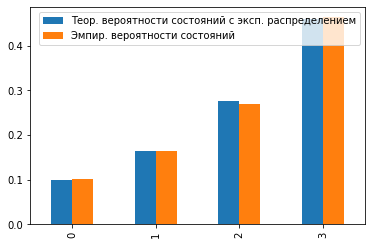

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.180147,0.178824
Вероятность отказа,0.459559,0.463528
Среднее количество заявок в СМО,2.095588,2.093378
Среднее количество заявок в очереди,1.194853,1.195895
Среднее время нахождения заявки в очереди,3.584559,3.587686
Среднее количество используемых каналов,0.900735,0.897483


In [49]:
sim = Simulator(rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/5)
sim.full_compare()

Далее иследуем СМО при различных значениях тех параметров, которые не зафиксированы условием задачи:

Попробуем изменить параметр распределния Эрланга (service_shape). По логике, при его увеличении должно увеличиться среднее время на обслуживание, т.к. распределение Эрланга с параметром k, характеризует время ожидания до того, как в Пуассоновском потоке событие произойдет k раз. Протестируем симуляцией:

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.007146,0.006477
1,0.043673,0.043794
2,0.247037,0.248941
3,0.702144,0.700788


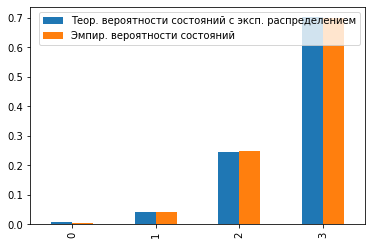

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.099285,0.099737
Вероятность отказа,0.702144,0.700788
Среднее количество заявок в СМО,2.644178,2.644041
Среднее количество заявок в очереди,1.651325,1.650518
Среднее время нахождения заявки в очереди,4.953975,4.951553
Среднее количество используемых каналов,0.992854,0.993523


In [50]:
sim = Simulator(rq_intensity=1/3,
              service_shape=2,
              service_intensity=1/5)
sim.full_compare()

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.000062,0.000029
1,0.003059,0.004148
2,0.146870,0.144858
3,0.850009,0.850964


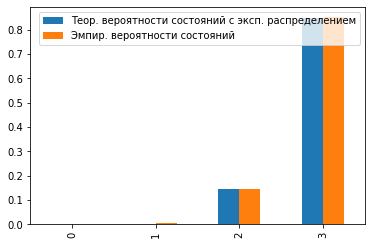

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.049997,0.049679
Вероятность отказа,0.850009,0.850964
Среднее количество заявок в СМО,2.846827,2.846757
Среднее количество заявок в очереди,1.846889,1.846786
Среднее время нахождения заявки в очереди,5.540667,5.540359
Среднее количество используемых каналов,0.999938,0.999971


In [51]:
sim = Simulator(rq_intensity=1/3,
              service_shape=4,
              service_intensity=1/5)
sim.full_compare()

Как можно заметить, вероятности сдвигаются больше в правую сторону, т.е. очередь плотнее заполняется, что и потверждает нашу гипотезу. Далее попробуем увеличить второй параметр закона Эрланга, по сути интенсивность:

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.25,0.242168
1,0.25,0.255031
2,0.25,0.253543
3,0.25,0.249257


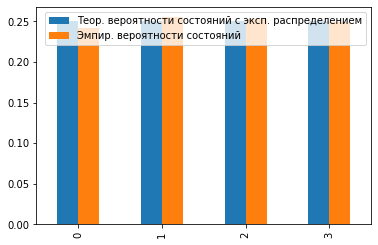

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.25,0.250248
Вероятность отказа,0.25,0.249257
Среднее количество заявок в СМО,1.50,1.509890
Среднее количество заявок в очереди,0.75,0.752058
Среднее время нахождения заявки в очереди,2.25,2.256174
Среднее количество используемых каналов,0.75,0.757832


In [52]:
sim = Simulator(rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/3)
sim.full_compare()

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.415385,0.419210
1,0.276923,0.276523
2,0.184615,0.183566
3,0.123077,0.120701


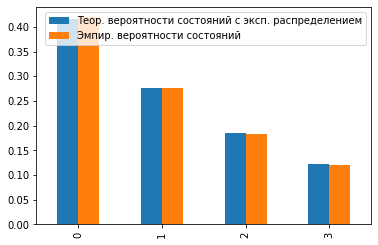

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.292308,0.293100
Вероятность отказа,0.123077,0.120701
Среднее количество заявок в СМО,1.015385,1.005757
Среднее количество заявок в очереди,0.430769,0.424967
Среднее время нахождения заявки в очереди,1.292308,1.274902
Среднее количество используемых каналов,0.584615,0.580790


In [53]:
sim = Simulator(rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/2)
sim.full_compare()

В данном случае, очередь становится более свободной, что логично, так как мы увеличивали интенсивность обслуживания. Далее попробуем увеличить оба параметра одновременно:

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.067862,0.074999
1,0.160229,0.152867
2,0.331192,0.331570
3,0.440717,0.440563


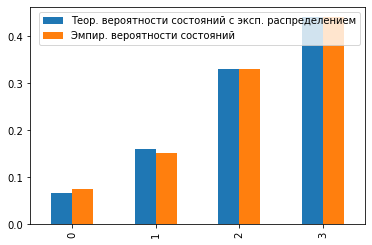

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.186428,0.186479
Вероятность отказа,0.440717,0.440563
Среднее количество заявок в СМО,2.144765,2.137697
Среднее количество заявок в очереди,1.212626,1.212697
Среднее время нахождения заявки в очереди,3.637879,3.638090
Среднее количество используемых каналов,0.932138,0.925001


In [54]:
sim = Simulator(rq_intensity=1/3,
              service_shape=2,
              service_intensity=1/2.5)
sim.full_compare()

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.049649,0.052029
1,0.150329,0.152394
2,0.370232,0.373674
3,0.429790,0.421902


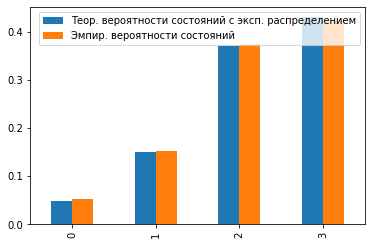

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.190070,0.192699
Вероятность отказа,0.429790,0.421902
Среднее количество заявок в СМО,2.180162,2.165450
Среднее количество заявок в очереди,1.229811,1.217479
Среднее время нахождения заявки в очереди,3.689433,3.652436
Среднее количество используемых каналов,0.950351,0.947971


In [55]:
sim = Simulator(rq_intensity=1/3,
              service_shape=4,
              service_intensity=1/1.25)
sim.full_compare()

В целом, можно наблюдать, что параметры компенсируют друг друга в каком-то смысле, однако первый все-таки имеет больший эффект, так как вероятности немного сдвигаются вправо. Далее попробуем уменшить интенсивность потока заявок:

,Теор. вероятности состояний с эксп. распределением,Эмпир. вероятности состояний
0,0.199707,0.205239
1,0.287859,0.281984
2,0.312728,0.314001
3,0.199707,0.198776


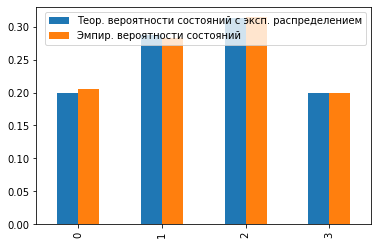

,Теор. показатели с эксп. распределением,Эмп. показатели
Абсолютная пропускная способность,0.160059,0.160245
Вероятность отказа,0.199707,0.198776
Среднее количество заявок в СМО,1.512434,1.506315
Среднее количество заявок в очереди,0.712141,0.711554
Среднее время нахождения заявки в очереди,3.560706,3.557769
Среднее количество используемых каналов,0.800293,0.794761


In [56]:
sim = Simulator(rq_intensity=1/5,
              service_shape=4,
              service_intensity=1/1.25)
sim.full_compare()

Вполне логично, система лучше справляется с обработкой